# 1. 📦 Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
import time
from datetime import timedelta, datetime
import os
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV, HalvingGridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, roc_auc_score, precision_recall_curve, precision_recall_curve, roc_curve, auc, make_scorer
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import optuna
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

from modules.Save_and_Load import load_model_with_threshold, save_model_with_threshold
from modules.graphs_and_tables import plot_ohlc_signals, plot_corr_by_distance, plot_correlation_matrix, plot_price_with_indicators, explain_model_mutual_info, explain_model_shap, plot_predict_signals, backtest_model,\
    evaluate_model_with_threshold, explain_model_permutation, show_class_balance

# 2. 📥 Загрузка и предобработка данных

In [34]:
df= pd.read_csv('downloads/LINK_test_m1_base_features.csv', compression='zstd')
df_test = pd.read_csv('downloads/LINK_train_m1_base_features.csv', compression='zstd')

Удаление дубликатов, бработка NaN

In [36]:
df = df.loc[:, ~df.columns.duplicated(keep='first')]
df.dropna(inplace=True)
df_test = df_test.loc[:, ~df_test.columns.duplicated(keep='first')]
df_test.dropna(inplace=True)

# 3. 📋 Отбор признаков

In [7]:
top_features = ['price_slope_2',
    'rsi14_speed_2', 
    'ema20_distance',
    'bullish_rsi_div_p14_s1',
    'bullish_rsi_div_p7_s1',
    'rsi21_speed_2',
    'ema50_distance',
    'rsi21',
    'ema9_speed_3',
    'ema100_distance',
    'price_slope_5',
    'block1_atr14_rel_change',
    'block1_ema200_rel_change',
    'macd_hist_slope_12_26_9_5',
    'block1_ema20_rel_change',
    'block2_ema200_rel_change',
    'ema20_speed_3',
    'block1_ema50_rel_change',
    'block3_ema200_rel_change',
    'block1_rsi21_mean',
    'block1_rsi21_rel_change',
    'rsi21_speed_10',
    'block4_ema20_rel_change',
    'block3_rsi21_mean',
    'block4_ema50_rel_change',
    'ema50_change_5',
    'rsi21_speed_30',
    'rsi14_speed_30',
    'rsi14_speed_10',
    'block4_rsi21_mean',
    'ema100_change_10',
    'buy', 'sell','buy_strong','sell_strong', 'buy_noised', 'sell_noised', 'Date','High','Low','Close','Open', 'Volume']

In [8]:
df = df[top_features]
df_test = df_test[top_features]
df.head(3)

,price_slope_2,rsi14_speed_2,ema20_distance,bullish_rsi_div_p14_s1,bullish_rsi_div_p7_s1,rsi21_speed_2,ema50_distance,rsi21,ema9_speed_3,ema100_distance,...,buy_strong,sell_strong,buy_noised,sell_noised,Date,High,Low,Close,Open,Volume
0,-0.0035,-0.006959,-0.001646,0,0,-0.005043,-0.001733,0.448799,-0.000115,0.000385,...,0.0,0.0,0.0,0.0,2022-03-10 00:40:00,13.984,13.981,13.984,13.982,28.3
1,0.0190,0.056020,0.000852,0,0,0.034470,0.000821,0.513812,0.000046,0.002913,...,0.0,0.0,0.0,0.0,2022-03-10 00:41:00,14.020,13.984,14.020,13.984,97.1
2,0.0160,0.047161,0.000511,0,0,0.029019,0.000513,0.506838,0.000199,0.002574,...,0.0,0.0,0.0,0.0,2022-03-10 00:42:00,14.025,14.016,14.016,14.020,249.4


# 4. ✂️ Разбиение выборки

## Разбиение выборки на train и valid

In [37]:
#Разбиваем выборку с учетом временных рядов:

X = df.drop(['buy', 'sell','buy_strong','sell_strong', 'buy_noised', 'sell_noised', 'Date','High','Low','Close','Open', 'Volume'],axis=1)
y = df['buy']
separate = int(len(X) * 0.8)
X_train = X.iloc[:separate]
X_valid = X.iloc[separate:]
y_train = y.iloc[:separate]
y_valid = y.iloc[separate:]
feature_columns = X.columns.tolist()

print(f'размер датасета = {df.shape}')
print(f'размер обучающей выборки Х = {X_train.shape}, y = {y_train.shape}')
print(f'размер валидационной выборки Х = {X_valid.shape}, y = {y_valid.shape}')

размер датасета = (1448421, 139)
размер обучающей выборки Х = (1158736, 127), y = (1158736,)
размер валидационной выборки Х = (289685, 127), y = (289685,)


Разбиение тестовой выборки **X_test**, **y-test**

In [39]:
X_test = df_test.drop(['buy', 'sell','buy_strong','sell_strong', 'buy_noised', 'sell_noised', 'Date','High','Low','Close','Open', 'Volume'],axis=1)
y_test = df_test['buy']


print(f'размер датасета = {X_test.shape}')

размер датасета = (305061, 127)


## Проверка временных диапазонов

Проверка временных диапазонов. Даты обучающей и тестовой выборок не должны пересекаться.

In [16]:
print(f"Диапазон дат обучающей выборки {df['Date'].agg(['min', 'max'])}")
print(f"Диапазон дат отложенной (тестовой) выборки {df_test['Date'].agg(['min', 'max'])}")

Диапазон дат обучающей выборки min    2022-03-10 00:40:00
max    2024-12-09 21:00:00
Name: Date, dtype: object
Диапазон дат отложенной (тестовой) выборки min    2024-12-12 00:40:00
max    2025-07-11 21:00:00
Name: Date, dtype: object


# 5. 🎯 Распределение целевой переменной (buy)

**Цель**: определение дисбаланса классов

## Распределение целевой переменной на всем df

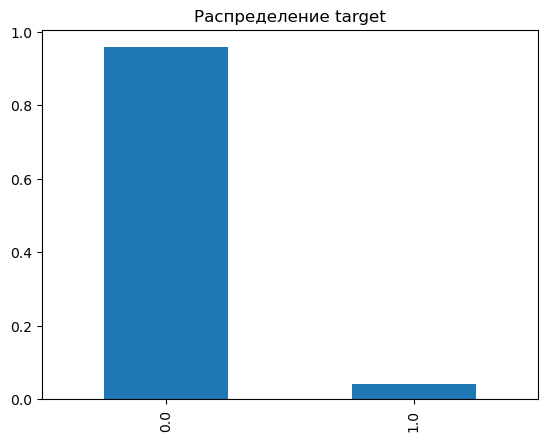

In [21]:
df['buy'].value_counts(normalize=True).plot(kind='bar', title='Распределение target');

## Распределение целевой переменной внутри выборок

**show_class_balance** Анализирует и визуализирует распределение классов по выборкам

Вход:
- y: целевая переменная всего датасета
- y_train: обучающая выборка
- y_valid: валидационная выборка
- y_test: тестовая выборка

Выход:
- Таблица с долями классов в каждой выборке
- Столбчатая диаграмма распределения
- Визуальная проверка сбалансированности данных

Что делает: Сравнивает пропорции классов между разными выборками для контроля репрезентативности разбиения

📊 Баланс классов (доли):
         Весь датасет    Обучающая    Валидационная    Тестовая
-----  --------------  -----------  ---------------  ----------
0.000           0.958        0.958            0.957       0.943
1.000           0.042        0.042            0.043       0.057


<Figure size 1000x500 with 0 Axes>

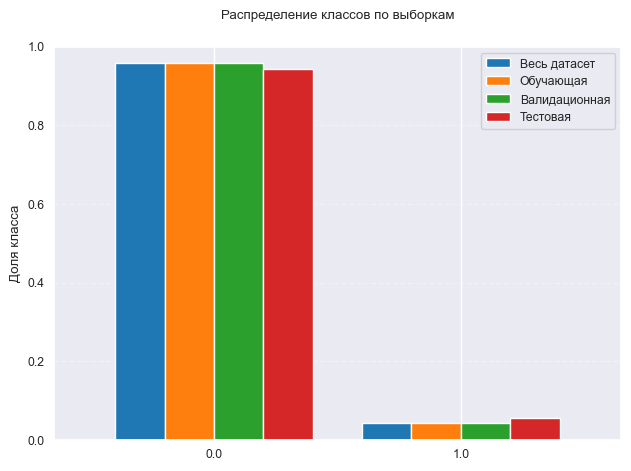

In [692]:
show_class_balance(y, y_train, y_valid, y_test)

# 6. 🔍 Поиск лучших параметров для моделей

## 📈 Логистическая регрессия

### LogReg + TimeSeriesSplit + GreedSearchCV

Обучение модели **LogisticRegression** и подбор оптимальных параметров через **GridSearchCV**.\
Для корректного расчета разбиений временных рядов используется **TimeSeriesSplit**.

In [93]:
start_time = time.time()

# Настройка TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)

# Упрощенный pipeline
pipeline = Pipeline([
    ('logreg', LogisticRegression(random_state=3, max_iter=100))
])

# Сетка параметров
params = {
    'logreg__C': [0.001, 0.01, 0.1, 1.0],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga'],
    'logreg__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 5}],
    'logreg__l1_ratio': [0.1, 0.5, 0.9]
}

# HalvingGridSearchCV
halving_logreg = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=tscv,
    scoring='f1',
    verbose=2,
    n_jobs=6,
    factor=3,
    min_resources='exhaust',
    aggressive_elimination=True
)

# Обучение
halving_logreg.fit(X_train, y_train)

print(f'⏱ Время выполнения: {time.time() - start_time:.2f} сек')



n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 14305
max_resources_: 1158736
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 144
n_resources: 14305
Fitting 2 folds for each of 144 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 42915
Fitting 2 folds for each of 48 candidates, totalling 96 fits
----------
iter: 2
n_candidates: 16
n_resources: 128745
Fitting 2 folds for each of 16 candidates, totalling 32 fits
----------
iter: 3
n_candidates: 6
n_resources: 386235
Fitting 2 folds for each of 6 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 1158705
Fitting 2 folds for each of 2 candidates, totalling 4 fits


C:\Users\nikita\anaconda3\envs\trading_env\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



⏱ Время выполнения: 14311.64 сек


C:\Users\nikita\anaconda3\envs\trading_env\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [94]:
# Предсказание
logreg_model = halving_logreg.best_estimator_
y_pred_logreg = logreg_model.predict(X_valid)

# Сохранение результатов
best_params_logreg = halving_logreg.best_params_

# Метрики
metrics_logreg = {
    'F1': f1_score(y_valid, y_pred_logreg),
    'Precision': precision_score(y_valid, y_pred_logreg),
    'Recall': recall_score(y_valid, y_pred_logreg)
}

print(f'✅ Лучшие параметры: {best_params_logreg}')
print(f'✅ F1: {metrics_logreg["F1"]:.4f}')
print(f'✅ Precision: {metrics_logreg["Precision"]:.4f}')
print(f'✅ Recall: {metrics_logreg["Recall"]:.4f}')


✅ Лучшие параметры: {'logreg__C': 1.0, 'logreg__class_weight': {0: 1, 1: 5}, 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
✅ F1: 0.2041
✅ Precision: 0.2389
✅ Recall: 0.1782


### ⚖️ Анализ попрога классификации для модели LogisticRegression

**evaluate_model_with_threshold** Оценивает модель с подбором оптимального порога и возвращает результаты

Вход:
- model: обученная модель классификации
- X_train, y_train: обучающая выборка
- X_valid, y_valid: валидационная выборка
- X_test, y_test: тестовая выборка (опционально)

Выход:
- Словарь с моделью, метриками и метаданными:
- Обученная модель
- Метрики (F1, Precision, Recall, ROC AUC) для всех выборок
- Оптимальный порог классификации
- Список использованных признаков

🎯 Лучший порог по F1 (Train): 0.3500
🎯 Лучший порог по F1 (Valid): 0.3700
✅ Усредненный оптимальный порог: 0.3600

📊 ROC AUC Scores:
✅ Train ROC AUC: 0.8216
✅ Valid ROC AUC: 0.8094

📊 Train set (Threshold = 0.3600):
✅ F1: 0.2444
✅ Precision: 0.1903
✅ Recall: 0.3414
✅ ROC AUC: 0.8216

📊 Valid set (Threshold = 0.3600):
✅ F1: 0.2370
✅ Precision: 0.1880
✅ Recall: 0.3207
✅ ROC AUC: 0.8094

📊 Test set (Threshold = 0.3600):
✅ F1: 0.2551
✅ Precision: 0.1940
✅ Recall: 0.3724
✅ ROC AUC: 0.8072


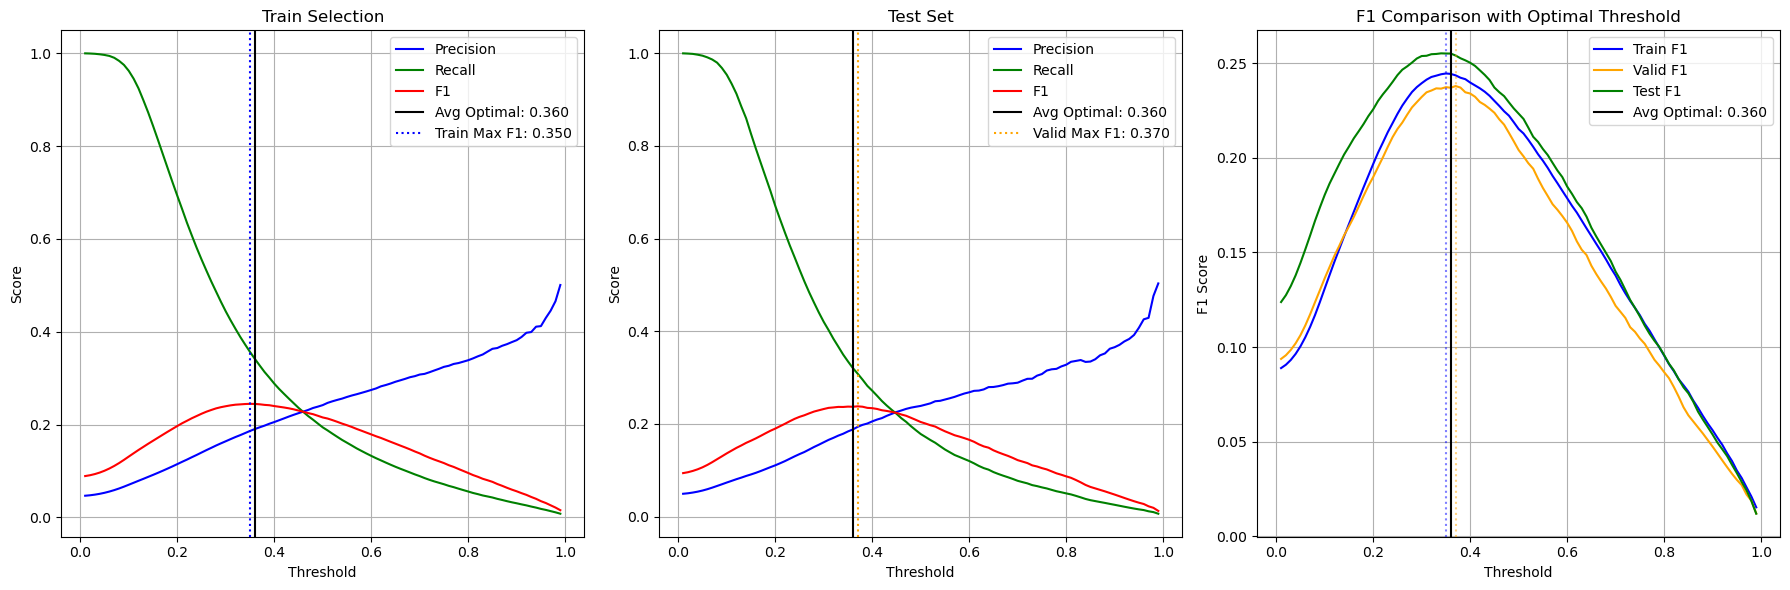

In [97]:
logreg_package = evaluate_model_with_threshold(logreg_model, X_train, y_train, X_valid, y_valid, X_test, y_test)

### 💾 Сохранения модели Логистической регрессии

In [99]:
# Сохранение новой модели
save_model_with_threshold(
    model_name='logreg_model_base_features',
    model=logreg_model,
    params=best_params_logreg,
    threshold = logreg_package['metrics']['optimal_threshold'], #logreg_package['metrics']['optimal_threshold'] - путь для функции evaluate_model_with_threshold
    features = list(X_train.columns)
)

✅ Модель сохранена в model_exports\logreg_model_base_features_with_threshold.pkl (сжатие: уровень 3)


### 🔄 Загрузка модели Логистической регрессии

In [101]:
logreg_package = load_model_with_threshold('logreg_model_base_features')  # Обратите внимание на имя переменной
logreg_model = logreg_package['model']
logreg_params = logreg_package['params']
logreg_threshold = logreg_package['threshold']

✅ Модель 'logreg_model_base_features' загружена из C:\Users\nikita\Documents\MagisterML\MyJupiter\trading_project\modules\..\model_exports\logreg_model_base_features_with_threshold.pkl


## 🌳 Случайный лес

### RandomForestClassifier + HalvingGridSearchCV + TimeSeriesSplit


Сперва для охвата широкого спектра параметров модели используется **HalvingGridSearchCV**.\
Для корректного расчета разбиений временных рядов используется **TimeSeriesSplit**.

In [105]:
start_time = time.time()

# 1. Параметры для HalvingGridSearchCV
param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 9, 15], 
    'max_features': ['sqrt', 'log2', 0.7], 
    'min_samples_leaf': [1, 3, 4],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 5}, {0: 1, 1: 10}],
    'bootstrap': [False] # Временные ряды, лучше пусть будет False
}

# 2. Настройка временных разбиений
tscv = TimeSeriesSplit(n_splits=2)

# 3. Модель RandomForestClassifier
base_model = RandomForestClassifier(
    random_state=3,
    n_jobs=6
)

# 4. Поиск по сетке с использованием HalvingGridSearchCV
halving_grid_search = HalvingGridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1',
    verbose=2,
    n_jobs=6,
    factor=3,
    min_resources='exhaust', 
    aggressive_elimination=True
)

halving_grid_search.fit(X_train, y_train)


print("⏱ Время выполнения: {:.2f} сек".format(time.time() - start_time))

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 4768
max_resources_: 1158736
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 324
n_resources: 4768
Fitting 2 folds for each of 324 candidates, totalling 648 fits
----------
iter: 1
n_candidates: 108
n_resources: 4768
Fitting 2 folds for each of 108 candidates, totalling 216 fits
----------
iter: 2
n_candidates: 36
n_resources: 14304
Fitting 2 folds for each of 36 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 12
n_resources: 42912
Fitting 2 folds for each of 12 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 4
n_resources: 128736
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 5
n_candidates: 2
n_resources: 386208
Fitting 2 folds for each of 2 candidates, totalling 4 fits
⏱ Время выполнения: 1899.96 сек


Выполняем **предсказание** на валидационных данных и выводим список **лучших параметров** и значения **F1, Precision, Recall**.

In [107]:
# Предсказание
forest_model = halving_grid_search.best_estimator_
y_pred_forest_model = forest_model.predict(X_valid)

# Сохранение результатов
best_params_forest_model = halving_grid_search.best_params_

# Метрики
metrics_forest_model = {
    'F1': f1_score(y_valid, y_pred_forest_model),
    'Precision': precision_score(y_valid, y_pred_forest_model),
    'Recall': recall_score(y_valid, y_pred_forest_model)
}

print(f'✅ Лучшие параметры: {best_params_forest_model}')
print(f'✅ F1: {metrics_forest_model["F1"]:.4f}')
print(f'✅ Precision: {metrics_forest_model["Precision"]:.4f}')
print(f'✅ Recall: {metrics_forest_model["Recall"]:.4f}')

✅ Лучшие параметры: {'bootstrap': False, 'class_weight': {0: 1, 1: 10}, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
✅ F1: 0.2370
✅ Precision: 0.1949
✅ Recall: 0.3025


### RandomForestClassifier + GridSearchCV + TimeSeriesSplit

Подбор значений в узком диапазоне используя **GridSearchCV** + **TimeSeriesSplit**

In [139]:
# 1. Параметры для GridSearchCV (узкий диапазон вокруг лучших параметров)
param_grid = {
    'n_estimators': [500],
    'max_depth': [5],
    'max_features': ['log2'],
    'min_samples_leaf': [4],
    'min_samples_split': [2],
    'class_weight': [{0: 1, 1: 10}],
    'bootstrap': [False]
}

# 2. Настройка временных разбиений
tscv = TimeSeriesSplit(n_splits=3)  # Уменьшили для скорости

# 3. Модель с лучшими параметрами из RandomizedSearch как базис
base_model = RandomForestClassifier(
    random_state=3,
    n_jobs=6
)

# 4. Поиск по сетке
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='precision',
    verbose=2,
    n_jobs=6
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestClassifier(n_jobs=6, random_state=3),
             n_jobs=6,
             param_grid={'bootstrap': [False], 'class_weight': [{0: 1, 1: 10}],
                         'max_depth': [5], 'max_features': ['log2'],
                         'min_samples_leaf': [4], 'min_samples_split': [2],
                         'n_estimators': [500]},
             scoring='precision', verbose=2)

Выполняем **предсказание** на валидационных данных и выводим список **лучших параметров** и значения **F1, Precision, Recall**.

In [141]:
# 5. Лучшая модель
forest_model = grid_search.best_estimator_

# Предсказание
y_pred_forest_model = forest_model.predict(X_valid)

# Сохранение результатов
best_params_forest_model = grid_search.best_params_

# Метрики
metrics_forest_model = {
    'F1': f1_score(y_valid, y_pred_forest_model),
    'Precision': precision_score(y_valid, y_pred_forest_model),
    'Recall': recall_score(y_valid, y_pred_forest_model)
}

print(f'✅ Лучшие параметры: {best_params_forest_model}')
print(f'✅ F1: {metrics_forest_model["F1"]:.4f}')
print(f'✅ Precision: {metrics_forest_model["Precision"]:.4f}')
print(f'✅ Recall: {metrics_forest_model["Recall"]:.4f}')

✅ Лучшие параметры: {'bootstrap': False, 'class_weight': {0: 1, 1: 10}, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
✅ F1: 0.2344
✅ Precision: 0.1898
✅ Recall: 0.3065


### ⚖️ Анализ попрога классификации для модели Random Forest

🎯 Лучший порог по F1 (Train): 0.4900
🎯 Лучший порог по F1 (Valid): 0.4900
✅ Усредненный оптимальный порог: 0.4900

📊 ROC AUC Scores:
✅ Train ROC AUC: 0.7891
✅ Valid ROC AUC: 0.7749

📊 Train set (Threshold = 0.4900):
✅ F1: 0.2422
✅ Precision: 0.1993
✅ Recall: 0.3088
✅ ROC AUC: 0.7891

📊 Valid set (Threshold = 0.4900):
✅ F1: 0.2352
✅ Precision: 0.1845
✅ Recall: 0.3246
✅ ROC AUC: 0.7749

📊 Test set (Threshold = 0.4900):
✅ F1: 0.2474
✅ Precision: 0.1877
✅ Recall: 0.3628
✅ ROC AUC: 0.7643


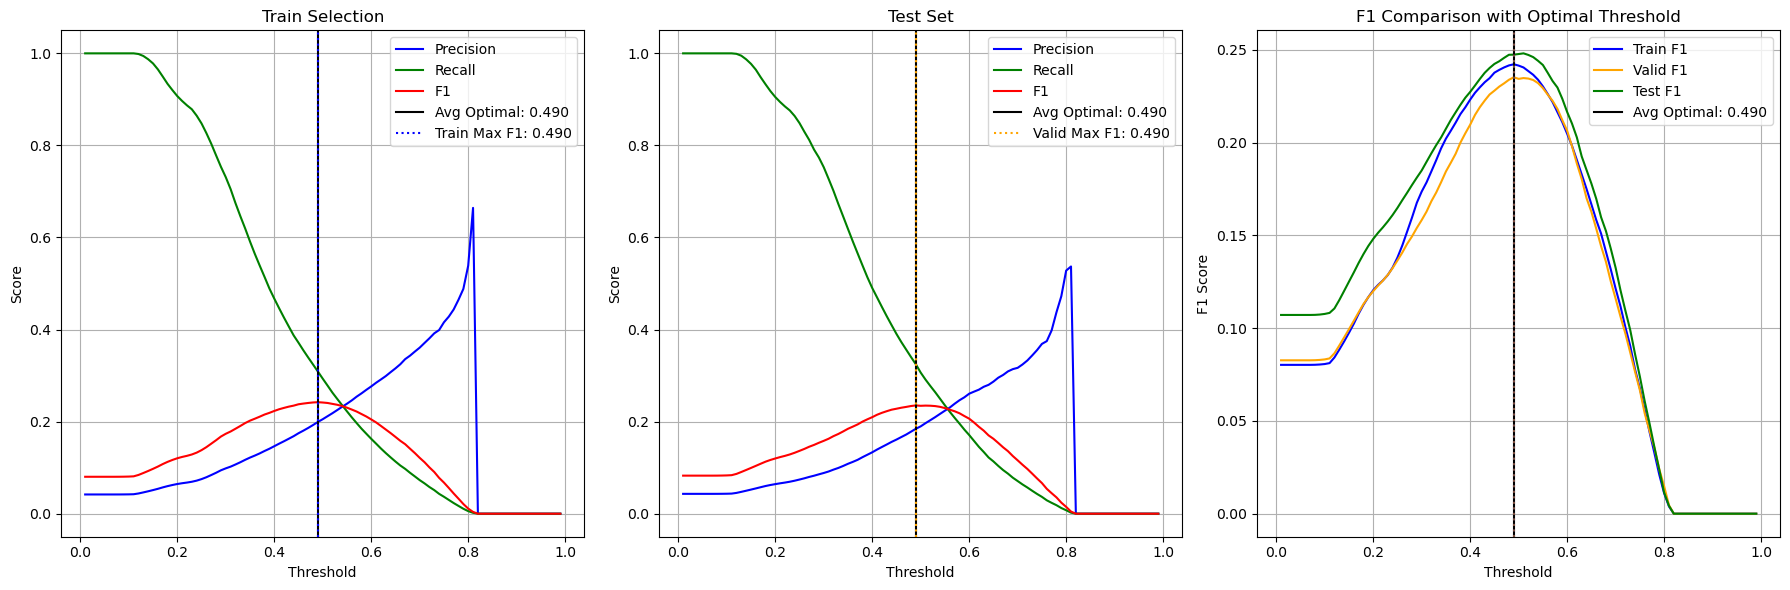

In [143]:
#forest_model = grid_search.best_estimator_
forest_model_package = evaluate_model_with_threshold(forest_model, X_train, y_train, X_valid, y_valid, X_test, y_test)

### 💾 Сохранение модели RandomForestClassifier

In [145]:
# Сохранение новой модели
save_model_with_threshold(
    model_name='forest_model_base_features',
    model=forest_model,
    params=forest_model.get_params,
    threshold = forest_model_package['metrics']['optimal_threshold'], #logreg_package['metrics']['optimal_threshold'] - путь для функции evaluate_model_with_threshold
    features = list(X_train.columns)
)

✅ Модель сохранена в model_exports\forest_model_base_features_with_threshold.pkl (сжатие: уровень 3)


### 🔄 Загрузка модели RandomForestClassifier

In [147]:
forest_model_package = load_model_with_threshold('forest_model_base_features')  # Обратите внимание на имя переменной
forest_model = forest_model_package['model']
forest_model_params = forest_model_package['params']
forest_model_threshold = forest_model_package['threshold']
forest_model_features = forest_model_package['features']

✅ Модель 'forest_model_base_features' загружена из C:\Users\nikita\Documents\MagisterML\MyJupiter\trading_project\modules\..\model_exports\forest_model_base_features_with_threshold.pkl


## 🌊 Бустинг

### LightGBM + Optuna + TimeSeriesSplit

In [40]:
# 1. Кастомная метрика
def precision_at_recall_threshold(y_true, y_pred):
    current_recall = recall_score(y_true, y_pred)
    if current_recall < 0.25:
        return 0.0
    return precision_score(y_true, y_pred)

scorer = make_scorer(precision_at_recall_threshold, greater_is_better=True)

# 2. TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)

# 3. Функция для Optuna
def objective(trial):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': 1,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e-1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10, log=True),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 5, 15),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False])
    }

    model = lgb.LGBMClassifier(
        **params,
        random_state=3,
        n_jobs=6,
        verbosity=1
    )

    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=scorer, n_jobs=6)
    return scores.mean()

In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-08-29 11:37:00,028] A new study created in memory with name: no-name-6d0547b8-13e6-420e-9f89-79318eca068b


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-29 11:37:36,491] Trial 0 finished with value: 0.13111961827816673 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 2, 'learning_rate': 0.0834969623722471, 'n_estimators': 219, 'min_child_samples': 12, 'colsample_bytree': 0.5061725253649033, 'reg_alpha': 0.08065755505637276, 'reg_lambda': 0.09530019309864561, 'scale_pos_weight': 11, 'min_split_gain': 0.1489051123856277, 'extra_trees': True}. Best is trial 0 with value: 0.13111961827816673.
[I 2025-08-29 11:38:39,283] Trial 1 finished with value: 0.12772448165326916 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 6, 'learning_rate': 0.05769389331500639, 'n_estimators': 468, 'min_child_samples': 17, 'colsample_bytree': 0.6370220956851854, 'reg_alpha': 0.00025910286765425453, 'reg_lambda': 0.8119915197543499, 'scale_pos_weight': 14, 'min_split_gain': 0.3875645863802749, 'extra_trees': False}. Best is trial 0 with value: 0.13111961827816673.
[I 2025-08-29 11:39:22,742] Trial 2 fini

In [42]:
print("Best params:", study.best_params)
print("Best score:", study.best_value)

# обучение на лучших параметрах
LightGBM_model = lgb.LGBMClassifier(**study.best_params, random_state=3, n_jobs=6, verbosity=-1)
LightGBM_model.fit(X_train, y_train)

Best params: {'boosting_type': 'dart', 'num_leaves': 42, 'max_depth': 12, 'learning_rate': 0.04147301295118322, 'n_estimators': 202, 'min_child_samples': 33, 'colsample_bytree': 0.761937532515515, 'reg_alpha': 0.022077594468849458, 'reg_lambda': 5.725366931642323, 'scale_pos_weight': 7, 'min_split_gain': 0.3497800839051174, 'extra_trees': False}
Best score: 0.20220563323474258


LGBMClassifier(boosting_type='dart', colsample_bytree=0.761937532515515,
               extra_trees=False, learning_rate=0.04147301295118322,
               max_depth=12, min_child_samples=33,
               min_split_gain=0.3497800839051174, n_estimators=202, n_jobs=6,
               num_leaves=42, random_state=3, reg_alpha=0.022077594468849458,
               reg_lambda=5.725366931642323, scale_pos_weight=7, verbosity=-1)

#### Визуализация процесса оптимизации гиперпараметров

**Parallel Coordinate Plot** - визуализирует, какие комбинации параметров приводят к лучшим результатам, помогая понять важность отдельных гиперпараметров

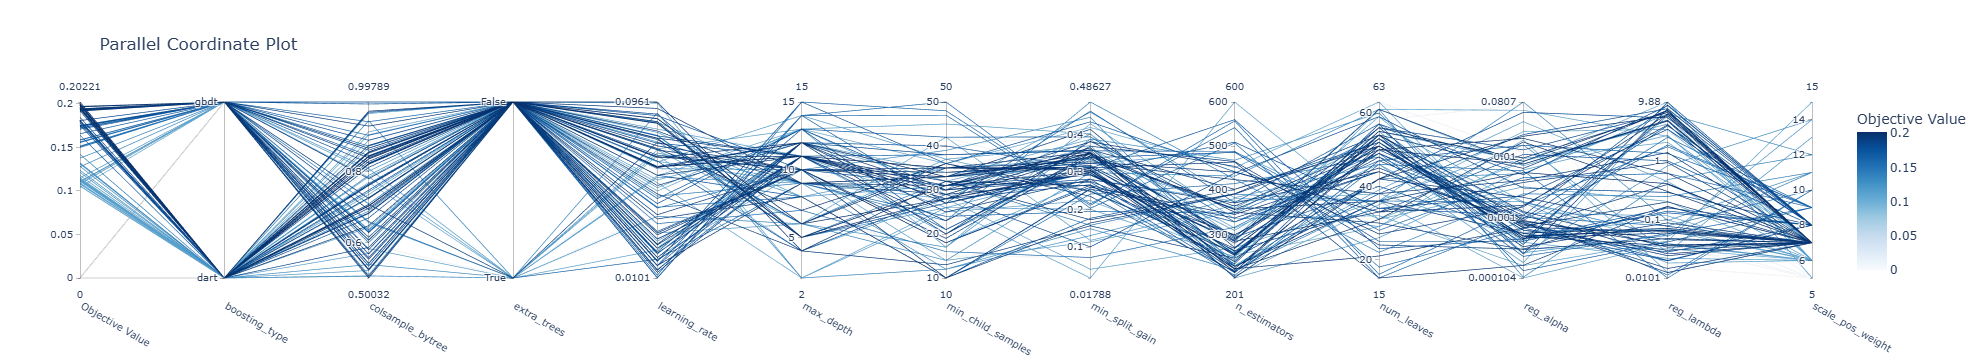

In [68]:
optuna.visualization.plot_parallel_coordinate(study)

**График зависимости метрики от количества итераций trial** - показывает динамику улучшения качества модели в процессе подбора параметров

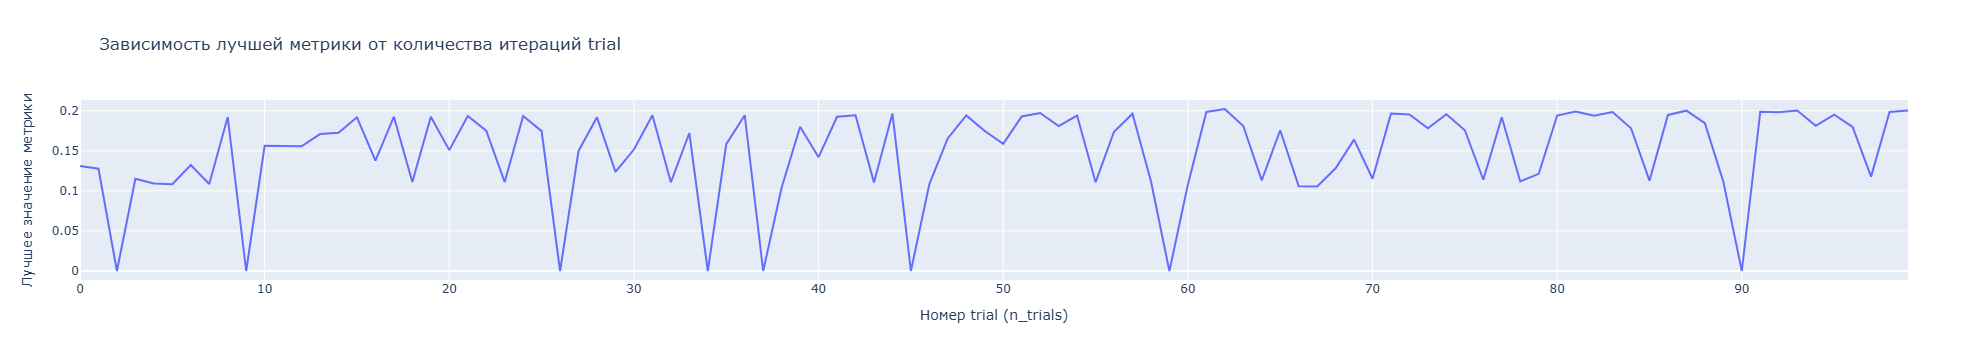

In [71]:
# Создаем DataFrame из результатов trials
df = study.trials_dataframe()
fig = px.line(df, x='number', y='value', 
              title='Зависимость лучшей метрики от количества итераций trial',
              labels={'number': 'Количество итераций trial (n_trials)', 'value': 'Лучшее значение метрики'})
fig.show()

### LightGBM + HalvingGridSearchCV + TimeSeriesSplit

In [75]:
# Кастомная метрика
def precision_at_recall_threshold(y_true, y_pred):
    current_recall = recall_score(y_true, y_pred)
    if current_recall < 0.25:
        return 0.0
    return precision_score(y_true, y_pred)

scorer = make_scorer(precision_at_recall_threshold, greater_is_better=True)

# Сетка для HalvingGridSearchCV вокруг лучших параметров Optuna
param_grid = {
    
    'num_leaves': [40, 42, 45],
    'reg_alpha': [0.0022, 0.004, 0.006],
    'reg_lambda': [5.0, 5.725, 6.5],
    'min_child_samples': [30, 33, 37],
    'colsample_bytree': [0.76, 1],
    'min_split_gain': [0.30, 0.35],
    
    # Фиксируем остальные параметры
    'boosting_type': ['dart'],
    'max_depth': [12],
    'scale_pos_weight': [7],
    'extra_trees': [False],
    'learning_rate': [0.041],
    'n_estimators': [200, 500],
}

tscv = TimeSeriesSplit(n_splits=2)

# Базовая модель с фиксированными параметрами
base_model = lgb.LGBMClassifier(
    random_state=3,
    n_jobs=6,
    verbosity=1
)

# HalvingGridSearchCV
halving_cv = HalvingGridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=tscv,
    scoring=scorer,
    factor=3,
    min_resources='exhaust', 
    aggressive_elimination=True,
    n_jobs=6,
    random_state=3,
    verbose=0
)

halving_cv.fit(X_train, y_train)
LightGBM_model = halving_cv.best_estimator_

print("Лучшие параметры после Halving:")
print(halving_cv.best_params_)
print(f"Лучший score после Halving: {halving_cv.best_score_:.6f}")

[LightGBM] [Info] Number of positive: 48424, number of negative: 1110312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.735316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27342
[LightGBM] [Info] Number of data points in the train set: 1158736, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041790 -> initscore=-3.132401
[LightGBM] [Info] Start training from score -3.132401
Лучшие параметры после Halving:
{'boosting_type': 'dart', 'colsample_bytree': 0.76, 'extra_trees': False, 'learning_rate': 0.041, 'max_depth': 12, 'min_child_samples': 37, 'min_split_gain': 0.35, 'n_estimators': 200, 'num_leaves': 42, 'reg_alpha': 0.004, 'reg_lambda': 5.0, 'scale_pos_weight': 7}
Лучший score после Halving: 0.111937
Улучшение: -0.086459


#### Обучение модели с лучшими параметрами на всей выборке

In [77]:
# 1. Получить лучшие параметры
best_params = halving_cv.best_params_

# 2. Создать НОВУЮ модель с этими параметрами
LightGBM_model = lgb.LGBMClassifier(
    **best_params,
    random_state=3,
    n_jobs=6,
    verbosity=-1
)

# 3. Обучить ее на ВСЕЙ тренировочной выборке
LightGBM_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='dart', colsample_bytree=0.76, extra_trees=False,
               learning_rate=0.041, max_depth=12, min_child_samples=37,
               min_split_gain=0.35, n_estimators=200, n_jobs=6, num_leaves=42,
               random_state=3, reg_alpha=0.004, reg_lambda=5.0,
               scale_pos_weight=7, verbosity=-1)

In [83]:
# предсказания
y_pred = LightGBM_model.predict(X_test)

metrics = {
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
}

print(f'✅ F1: {metrics["F1"]:.4f}')
print(f'✅ Precision: {metrics["Precision"]:.4f}')
print(f'✅ Recall: {metrics["Recall"]:.4f}')

✅ F1: 0.2610
✅ Precision: 0.2100
✅ Recall: 0.3447


### ⚖️ Анализ попрога классификации для модели LightGBM

🎯 Лучший порог по F1 (Train): 0.4800
🎯 Лучший порог по F1 (Valid): 0.4700
✅ Усредненный оптимальный порог: 0.4750

📊 ROC AUC Scores:
✅ Train ROC AUC: 0.8369
✅ Valid ROC AUC: 0.8189

📊 Train set (Threshold = 0.4750):
✅ F1: 0.2587
✅ Precision: 0.2029
✅ Recall: 0.3568
✅ ROC AUC: 0.8369

📊 Valid set (Threshold = 0.4750):
✅ F1: 0.2513
✅ Precision: 0.1953
✅ Recall: 0.3523
✅ ROC AUC: 0.8189

📊 Test set (Threshold = 0.4750):
✅ F1: 0.2606
✅ Precision: 0.1919
✅ Recall: 0.4057
✅ ROC AUC: 0.8036


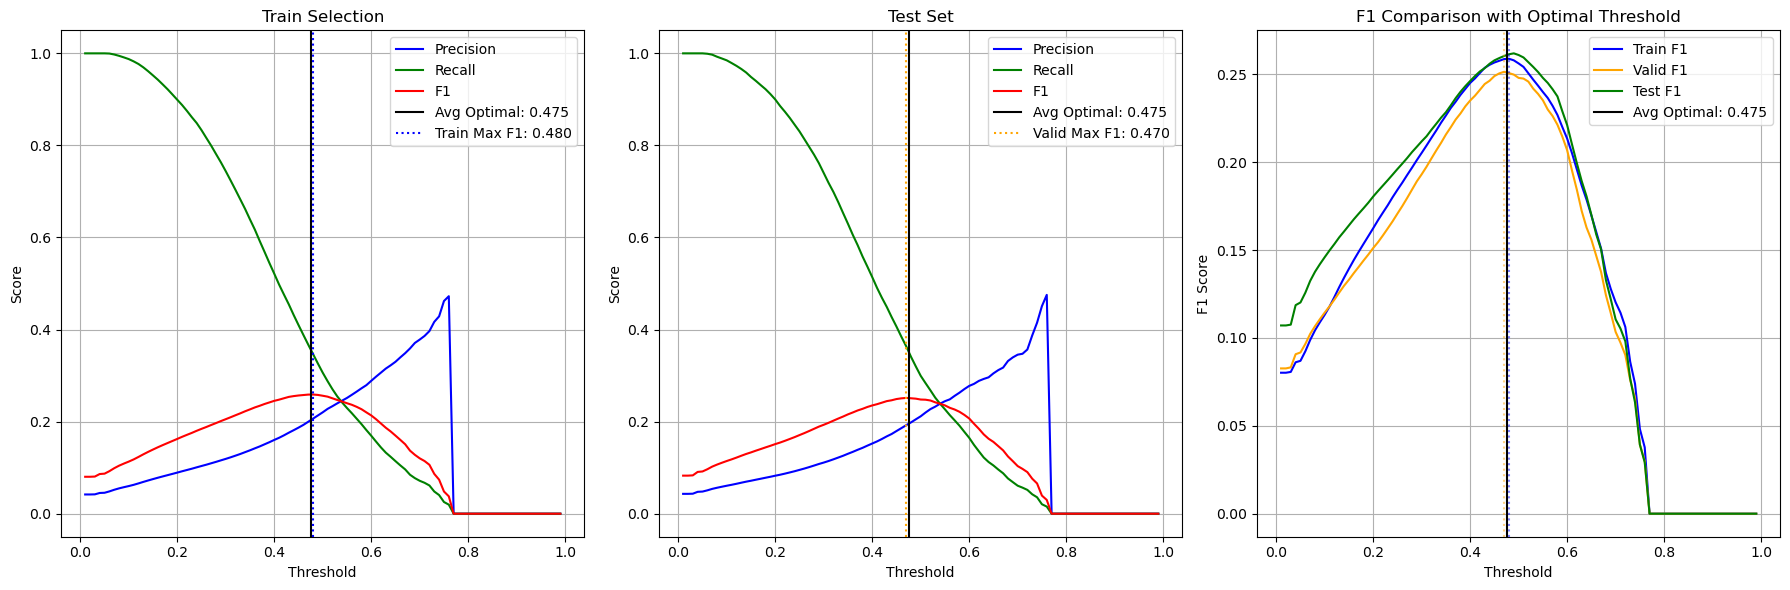

In [79]:
LightGBM_model_package = evaluate_model_with_threshold(LightGBM_model, X_train, y_train, X_valid, y_valid, X_test, y_test)

### 💾 Сохранение модели LightGBM.

In [80]:
# Сохранение новой модели
save_model_with_threshold(
    model_name='LightGBM_model_base_features',
    model=LightGBM_model,
    params=LightGBM_model.get_params,
    threshold = 0.7, #LightGBM_model_package['metrics']['optimal_threshold'], #- путь для функции evaluate_model_with_threshold
    features = list(X_train.columns)
)

✅ Модель сохранена в model_exports\LightGBM_model_base_features_with_threshold.pkl (сжатие: уровень 3)


### 🔄 Загрузка модели LightGBM

In [113]:
LightGBM_model_package = load_model_with_threshold('LightGBM_model_base_features')  # Обратить внимание на имя переменной _top_features
LightGBM_model = LightGBM_model_package['model']
LightGBM_model_params = LightGBM_model_package['params']
LightGBM_model_threshold = LightGBM_model_package['threshold']
LightGBM_model_features = LightGBM_model_package['features']

✅ Модель 'LightGBM_model_base_features' загружена из C:\Users\nikita\Documents\MagisterML\MyJupiter\trading_project\modules\..\model_exports\LightGBM_model_base_features_with_threshold.pkl


# 7. 🖥️ Матрица расхождений для разных моделей

Сравнение предсказаний моделей на валидационной выборке и анализ, насколько они согласованы между собой.\
**Каппа Коэна** (cohen_kappa_score) - метрика согласия между моделями

In [148]:
# Предсказания моделей по отдельности
y_pred_1 = LightGBM_model.predict(X_valid)
y_pred_2 = forest_model.predict(X_valid)

# Совпадение ошибок
disagree = np.sum((y_pred_1 == y_valid) != (y_pred_2 == y_valid))
print(f"Модели расходятся в {disagree/len(y_valid):.1%} случаев")
print(f"Согласие моделей (Каппа Коэна): {cohen_kappa_score(y_pred_1, y_pred_2):.2f}")

Модели расходятся в 2.5% случаев
Согласие моделей (Каппа Коэна): 0.79


# 8. 🔔 Сигналы модели

**plot_predict_signals** Визуализирует OHLC график с истинными и предсказанными торговыми сигналами

Аргументы:
- df с колонками: 'Open','High','Low','Close','buy','sell'
- y_pred: массив предсказаний модели (опционально)
- pred_threshold: порог бинаризации предсказаний
- start_idx: начальный индекс участка
- end_idx: конечный индекс участка

Отображает:
- Линии OHLC цен
- Истинные buy/sell сигналы (зеленые/красные маркеры)
- Предсказанные buy сигналы модели (синие маркеры)

## Визуализация модели LightGBM

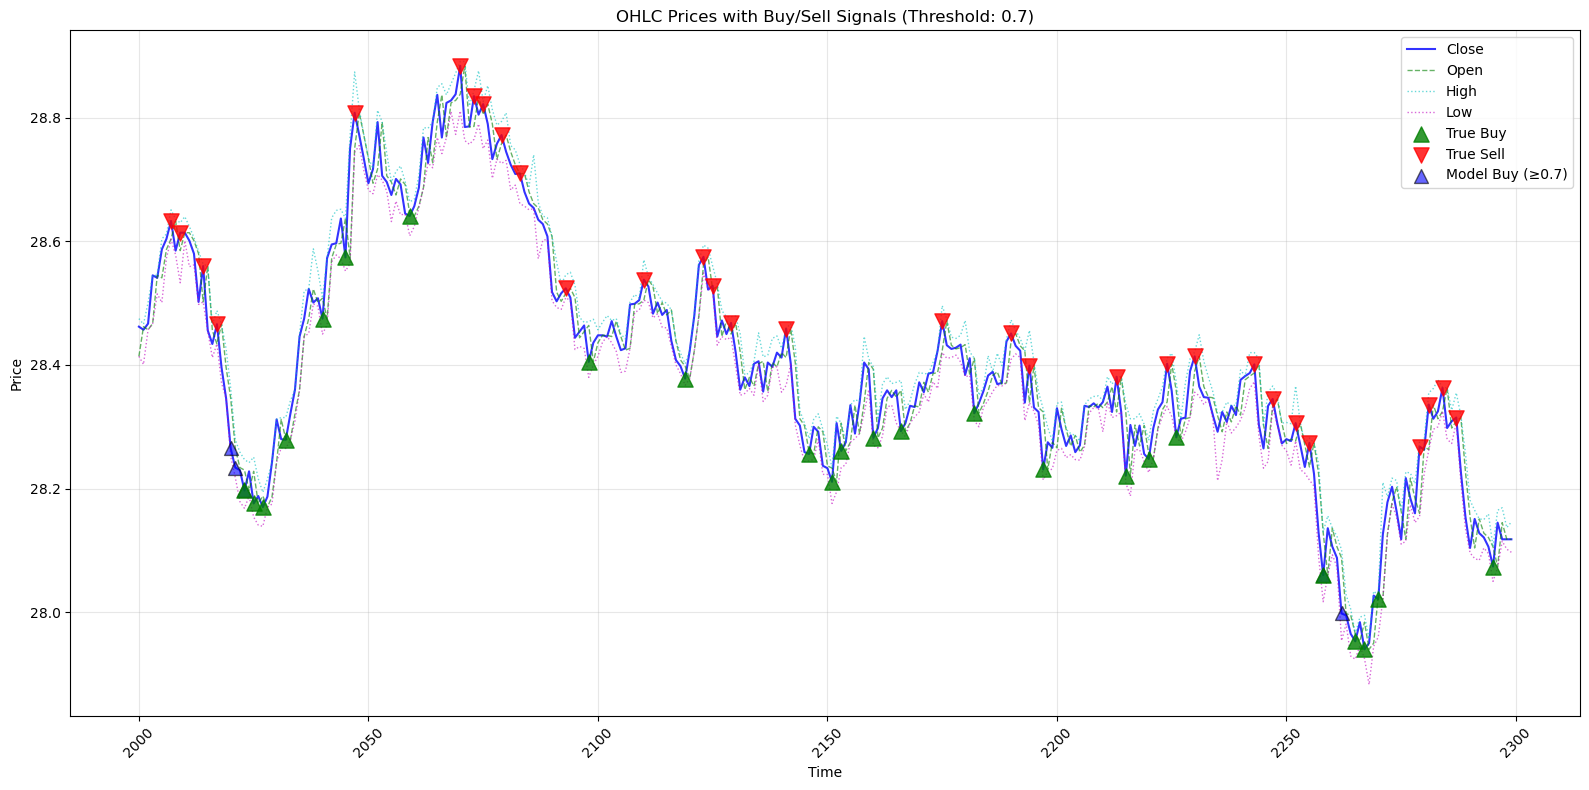

In [152]:
# Визуализация с разными порогами
y_pred_proba_LightGBM = LightGBM_model.predict_proba(X_test)[:, 1]
plot_predict_signals(df_test, y_pred_proba_LightGBM, pred_threshold=0.7, start_idx=2000, end_idx=2300)

## Визуализация модели Random Forest

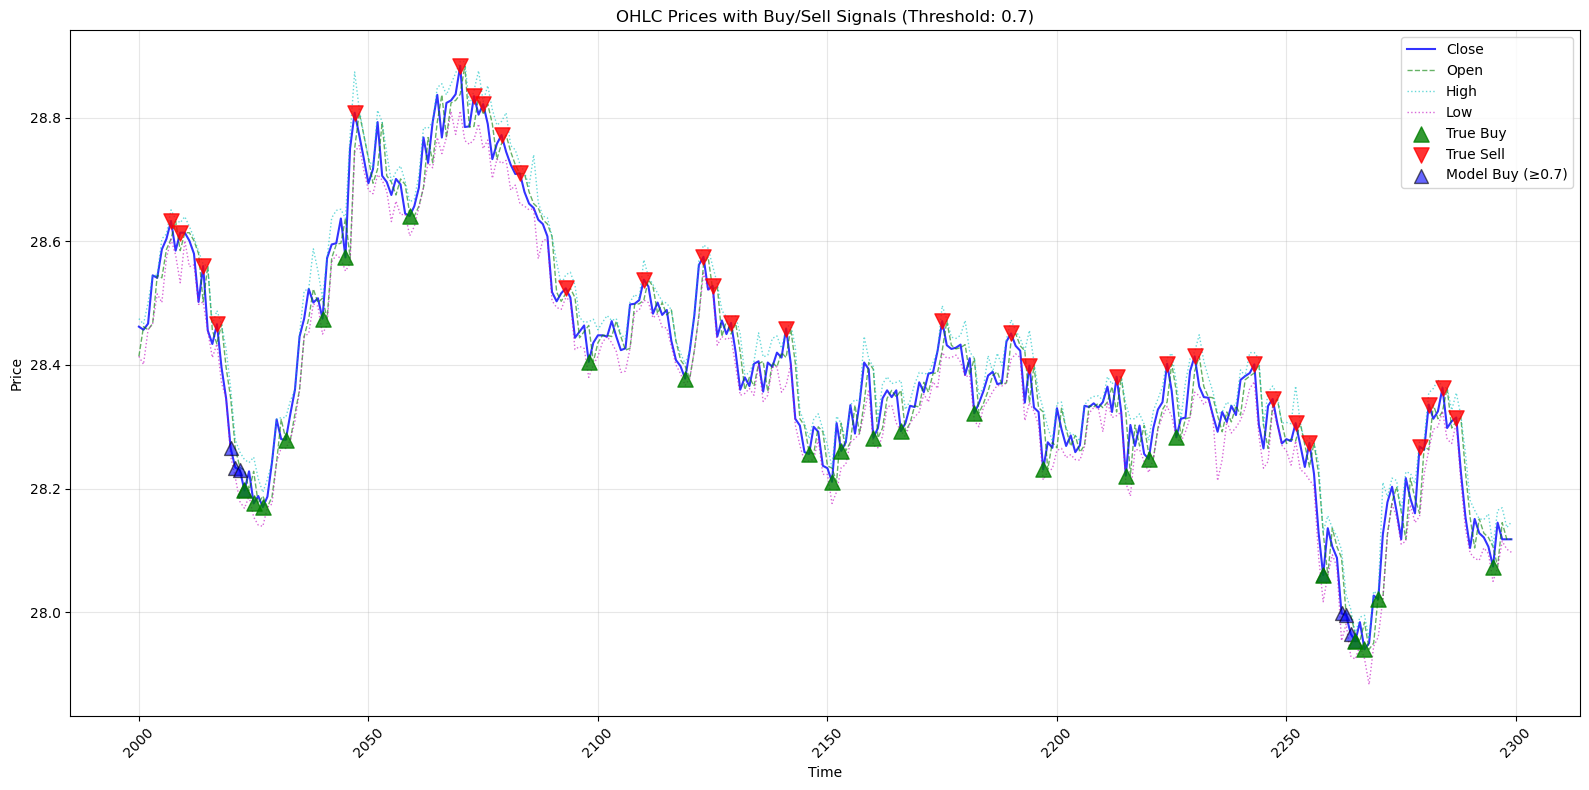

In [154]:
# Визуализация модели Random Forest
y_pred_proba_forest = forest_model.predict_proba(X_test)[:, 1]
plot_predict_signals(df_test, y_pred_proba_forest, pred_threshold=0.70, start_idx=2000, end_idx=2300)

## Визуализация модели LogReg

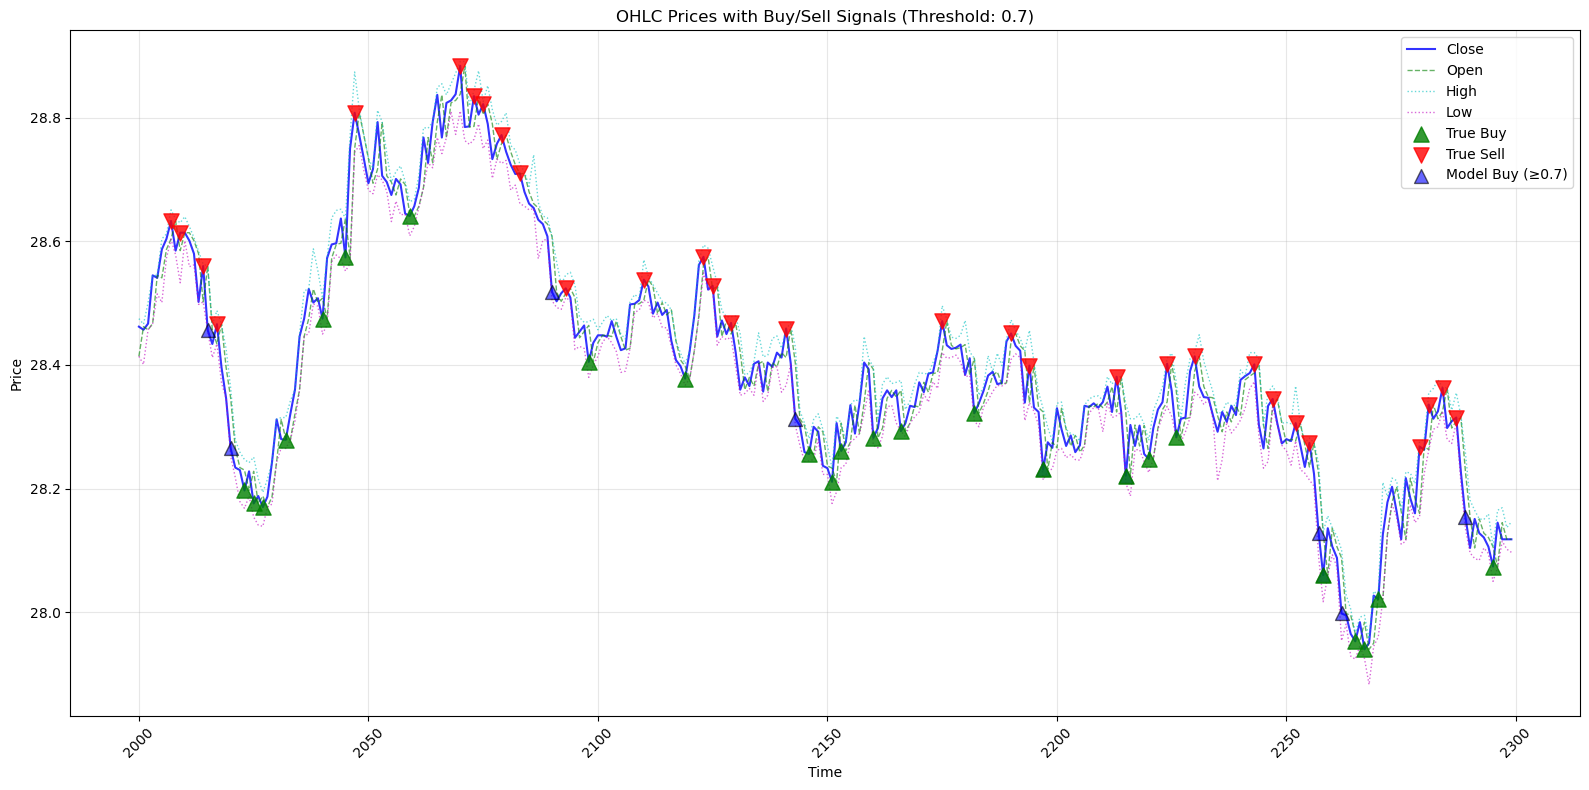

In [156]:
# Визуализация модели Random Forest
y_pred_proba_logreg = logreg_model.predict_proba(X_test)[:, 1]
plot_predict_signals(df_test, y_pred_proba_logreg, pred_threshold=0.70, start_idx=2000, end_idx=2300)

# 9. 🔄  Бэктест торговой модели

**backtest_model** Проводит пошаговый бэктест торговой модели с TP/SL и анализирует результаты

Аргументы:
- df: DataFrame с признаками и ценовыми данными
- model: обученная модель машинного обучения
- X_train: тренировочные данные, для необходимых признаков
- threshold: порог для торговых сигналов
- tp_pct: уровень тейк-профита (%)
- rr: соотношение риск/прибыль
- plot: флаг отображения графиков

Возвращает:
- Общую прибыль и счетчик TP/SL сделок
- Максимальную серию убытков
- Помесячную статистику
- Таблицу всех сделок
- Графики кривой капитала и месячной прибыли

## Бэктест LightGBM

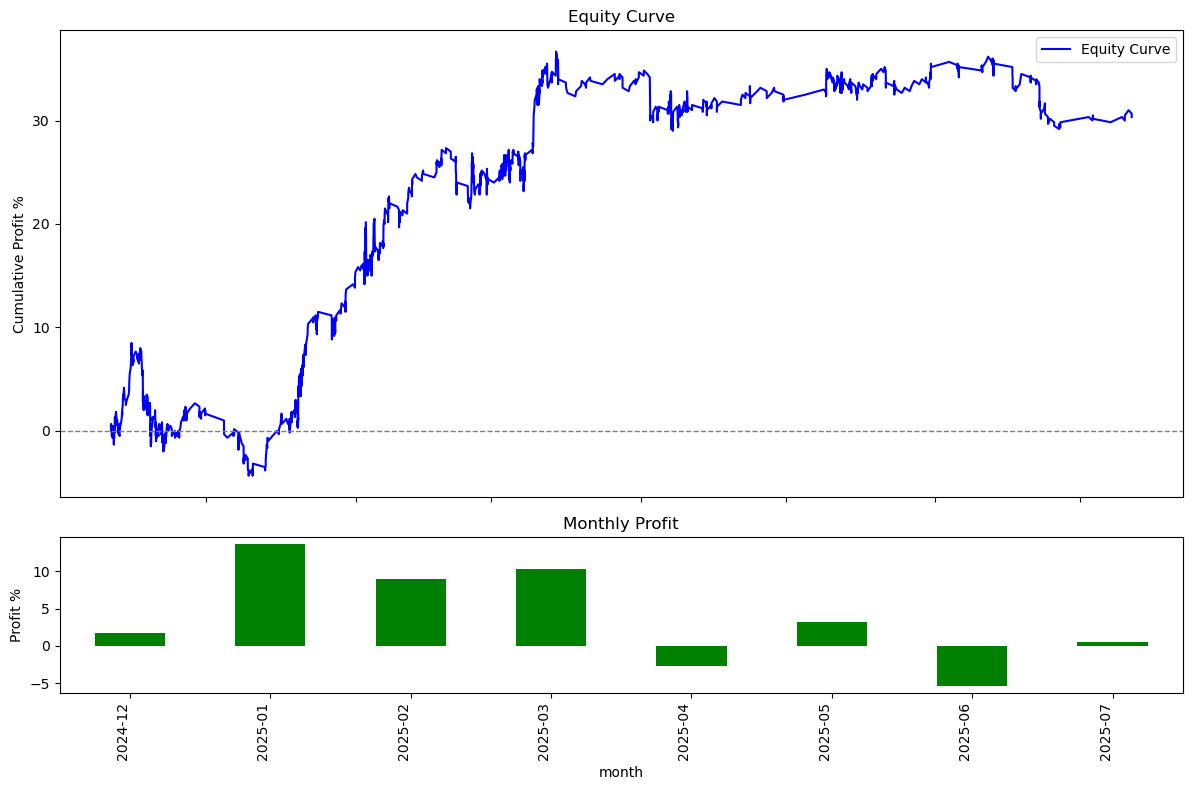

Общая прибыль: 30.33%
TP сделок: 738, SL сделок: 1016
Макс. серия убытков: 12
month
2024-12     1.666667
2025-01    13.666667
2025-02     9.000000
2025-03    10.333333
2025-04    -2.666667
2025-05     3.166667
2025-06    -5.333333
2025-07     0.500000
Freq: M, Name: profit_pct, dtype: float64


In [124]:
results = backtest_model(df=df_test, model=LightGBM_model, X_train=X_train, threshold=0.70, tp_pct=0.005, rr=1.5, plot=True)

# Посмотрим результат
print(f"Общая прибыль: {results['total_profit']:.2f}%")
print(f"TP сделок: {results['tp_count']}, SL сделок: {results['sl_count']}")
print(f"Макс. серия убытков: {results['max_sl_streak']}")
print(results['monthly_profit'])

## Бэктест Логистической регрессии

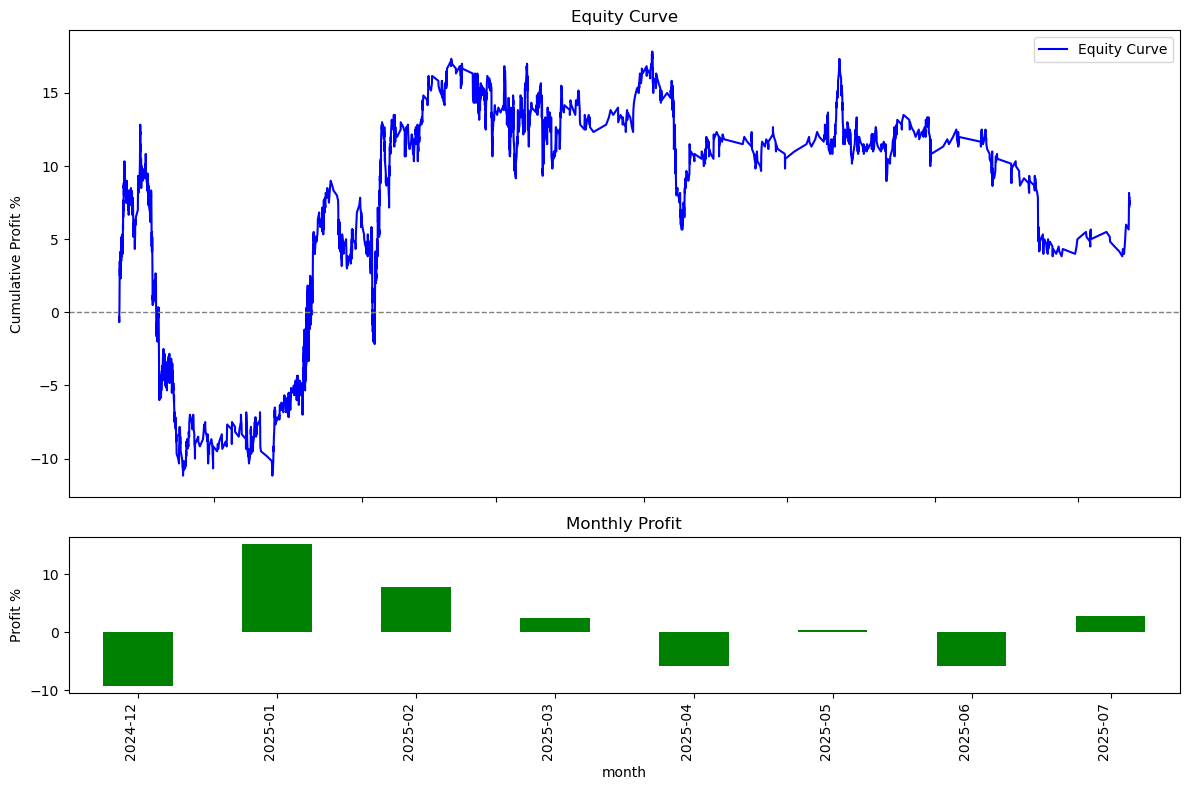

Общая прибыль: 7.83%
TP сделок: 1519, SL сделок: 2255
Макс. серия убытков: 15
month
2024-12    -9.166667
2025-01    15.166667
2025-02     7.833333
2025-03     2.500000
2025-04    -5.833333
2025-05     0.333333
2025-06    -5.833333
2025-07     2.833333
Freq: M, Name: profit_pct, dtype: float64


In [125]:
results = backtest_model(df=df_test, model=logreg_model, X_train=X_train, threshold=0.70, tp_pct=0.005, rr=1.5, plot=True)

# Посмотрим результат
print(f"Общая прибыль: {results['total_profit']:.2f}%")
print(f"TP сделок: {results['tp_count']}, SL сделок: {results['sl_count']}")
print(f"Макс. серия убытков: {results['max_sl_streak']}")
print(results['monthly_profit'])

## Бэктест RandomForest

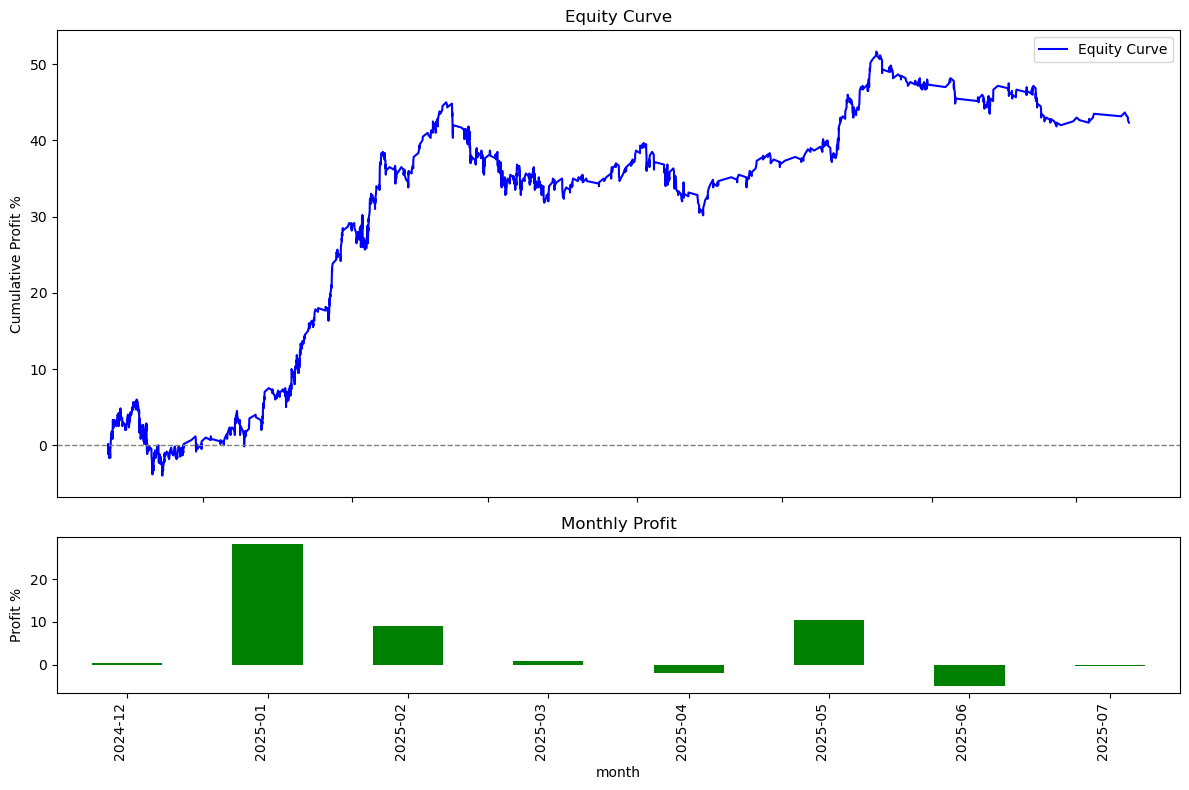

Общая прибыль: 42.33%
TP сделок: 938, SL сделок: 1280
Макс. серия убытков: 12
month
2024-12     0.500000
2025-01    28.166667
2025-02     9.000000
2025-03     1.000000
2025-04    -1.833333
2025-05    10.500000
2025-06    -4.833333
2025-07    -0.166667
Freq: M, Name: profit_pct, dtype: float64


In [126]:
results = backtest_model(df=df_test, model=forest_model, X_train=X_train, threshold=0.70, tp_pct=0.005, rr=1.5, plot=True)

# Посмотрим результат
print(f"Общая прибыль: {results['total_profit']:.2f}%")
print(f"TP сделок: {results['tp_count']}, SL сделок: {results['sl_count']}")
print(f"Макс. серия убытков: {results['max_sl_streak']}")
print(results['monthly_profit'])

# 🚀 Проверка модели на новых данных

Проверка отложена до повышения бызовых метрик f1, precision.